In [1]:
import os
from pathlib import Path
import glob
import re
import numpy as np
import pandas as pd
import h5py
import torch
import librosa
import ast
import string
import zipfile
from tqdm.notebook import tqdm
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import cv2
import nibabel as nib
from nilearn import plotting
from nilearn.maskers import NiftiLabelsMasker
import ipywidgets as widgets
from ipywidgets import VBox, Dropdown, Button
from IPython.display import Video, display, clear_output
from moviepy import VideoFileClip
from transformers import BertTokenizer, BertModel
from torchvision.transforms import Compose, Lambda, CenterCrop
from torchvision.models.feature_extraction import create_feature_extractor
from pytorchvideo.transforms import Normalize, UniformTemporalSubsample, ShortSideScale

In [2]:
root_data_dir = '../algonauts_2025_challenge_tutorial_data'

In [3]:
# Function to list available subjects based on folder names
def list_subjects(fmri_dir):
    return sorted([d for d in os.listdir(fmri_dir) if d.startswith('sub-')])

# Function to explore HDF5 file structure and organize datasets by season/movie
def explore_h5_file(file_path, selected_dataset):
    season_movie_dict = {}
    with h5py.File(file_path, 'r') as h5_file:
        for name, obj in h5_file.items():
            if isinstance(obj, h5py.Dataset):
                if selected_dataset == 'Friends':
                    season_movie = name.split('_')[1].split('-')[1][:3]  # Extract season (e.g., 's01')
                elif selected_dataset == 'Movie10':
                    season_movie = name.split('_')[1].split('-')[1][:-2]  # Extract movie (e.g., 'bourne')
                season_movie_dict.setdefault(season_movie, []).append(f"{name} (Shape: {obj.shape})")
    return season_movie_dict

# Function to display datasets in a DataFrame
def display_datasets_in_table(season_dict):
    max_len = max(len(v) for v in season_dict.values())
    df = pd.DataFrame({k: v + [''] * (max_len - len(v)) for k, v in sorted(season_dict.items())})
    display(df)

# Create subject and dataset selector widget
def create_subject_selector(fmri_dir):
    subjects = list_subjects(fmri_dir)
    dataset_options = ['Friends', 'Movie10']

    subject_dropdown = Dropdown(options=subjects, description='Select Subject:')
    dataset_dropdown = Dropdown(options=dataset_options, description='Select Dataset:')
    button = Button(description="Explore File", button_style='primary')

    def on_button_click(b):
        clear_output(wait=True)
        display(VBox([subject_dropdown, dataset_dropdown, button]))

        selected_subject = subject_dropdown.value
        selected_dataset = dataset_dropdown.value

        if selected_dataset == 'Friends':
            h5_file_path = os.path.join(
                fmri_dir, selected_subject, 'func',
                f"{selected_subject}_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"
            )
        elif selected_dataset == 'Movie10':
            h5_file_path = os.path.join(
                fmri_dir, selected_subject, 'func',
                f"{selected_subject}_task-movie10_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_bold.h5"
            )

        if os.path.exists(h5_file_path):
            season_movie_data = explore_h5_file(h5_file_path, selected_dataset)
            display_datasets_in_table(season_movie_data)
        else:
            print("Error: HDF5 file not found.")

    button.on_click(on_button_click)
    display(VBox([subject_dropdown, dataset_dropdown, button]))

# Base directory for fMRI data
fmri_dir = root_data_dir + "/algonauts_2025.competitors/fmri/"

# Run the subject selector widget
create_subject_selector(fmri_dir)


,s01,s02,s03,s04,s05,s06
0,"ses-001_task-s01e02a (Shape: (482, 1000))","ses-010_task-s02e01a (Shape: (477, 1000))","ses-019_task-s03e01a (Shape: (491, 1000))","ses-027_task-s04e01a (Shape: (468, 1000))","ses-036_task-s05e01a (Shape: (439, 1000))","ses-052_task-s06e01a (Shape: (465, 1000))"
1,"ses-001_task-s01e02b (Shape: (482, 1000))","ses-010_task-s02e01b (Shape: (477, 1000))","ses-019_task-s03e01b (Shape: (491, 1000))","ses-027_task-s04e01b (Shape: (468, 1000))","ses-036_task-s05e01b (Shape: (474, 1000))","ses-052_task-s06e01b (Shape: (499, 1000))"
2,"ses-001_task-s01e03a (Shape: (472, 1000))","ses-011_task-s02e02a (Shape: (450, 1000))","ses-019_task-s03e02a (Shape: (475, 1000))","ses-027_task-s04e02a (Shape: (478, 1000))","ses-036_task-s05e02a (Shape: (495, 1000))","ses-053_task-s06e02a (Shape: (453, 1000))"
3,"ses-001_task-s01e03b (Shape: (472, 1000))","ses-011_task-s02e02b (Shape: (450, 1000))","ses-019_task-s03e02b (Shape: (475, 1000))","ses-027_task-s04e02b (Shape: (478, 1000))","ses-036_task-s05e02b (Shape: (531, 1000))","ses-053_task-s06e02b (Shape: (487, 1000))"
4,"ses-002_task-s01e04a (Shape: (503, 1000))","ses-011_task-s02e03a (Shape: (464, 1000))","ses-019_task-s03e03a (Shape: (454, 1000))","ses-028_task-s04e03a (Shape: (445, 1000))","ses-037_task-s05e03a (Shape: (444, 1000))","ses-053_task-s06e03a (Shape: (439, 1000))"
5,"ses-002_task-s01e04b (Shape: (503, 1000))","ses-011_task-s02e03b (Shape: (464, 1000))","ses-019_task-s03e03b (Shape: (454, 1000))","ses-028_task-s04e03b (Shape: (445, 1000))","ses-037_task-s05e03b (Shape: (474, 1000))","ses-053_task-s06e03b (Shape: (473, 1000))"
6,"ses-002_task-s01e05a (Shape: (468, 1000))","ses-011_task-s02e04a (Shape: (454, 1000))","ses-020_task-s03e04a (Shape: (473, 1000))","ses-028_task-s04e04a (Shape: (453, 1000))","ses-037_task-s05e04a (Shape: (488, 1000))","ses-053_task-s06e04a (Shape: (439, 1000))"
7,"ses-002_task-s01e05b (Shape: (468, 1000))","ses-011_task-s02e04b (Shape: (454, 1000))","ses-020_task-s03e04b (Shape: (473, 1000))","ses-028_task-s04e04b (Shape: (453, 1000))","ses-037_task-s05e04b (Shape: (524, 1000))","ses-054_task-s06e04b (Shape: (474, 1000))"
8,"ses-003_task-s01e01a (Shape: (592, 1000))","ses-011_task-s02e05a (Shape: (455, 1000))","ses-020_task-s03e05a (Shape: (484, 1000))","ses-028_task-s04e05a (Shape: (471, 1000))","ses-041_task-s05e05a (Shape: (486, 1000))","ses-054_task-s06e05a (Shape: (452, 1000))"
9,"ses-003_task-s01e01b (Shape: (592, 1000))","ses-011_task-s02e05b (Shape: (455, 1000))","ses-020_task-s03e05b (Shape: (484, 1000))","ses-028_task-s04e05b (Shape: (471, 1000))","ses-041_task-s05e05b (Shape: (521, 1000))","ses-054_task-s06e05b (Shape: (486, 1000))"


In [12]:
def plot_fmri_on_brain(chunk_index, fmri_file_path, atlas_path, dataset_name,
    hrf_delay):
    """
    Map fMRI responses to brain parcels and plot it on a glass brain.

    Parameters
    ----------
    chunk_index : pandas.Series
        The selected chunk from the transcript, used to determine the fMRI
        sample.
    fmri_file_path : str
        Path to the HDF5 file containing fMRI data.
    atlas_path : str
        Path to the atlas NIfTI file.
    dataset_name : str
        Name of the dataset inside the HDF5 file.
    hrf_delay : int
        fMRI detects the BOLD (Blood Oxygen Level Dependent) response, a signal
        that reflects changes in blood oxygenation levels in response to
        activity in the brain. Blood flow increases to a given brain region in
        response to its activity. This vascular response, which follows the
        hemodynamic response function (HRF), takes time. Typically, the HRF
        peaks around 5–6 seconds after a neural event: this delay reflects the
        time needed for blood oxygenation changes to propagate and for the fMRI
        signal to capture them. Therefore, this parameter introduces a delay
        between stimulus chunks and fMRI samples for a better correspondence
        between input stimuli and the brain response. For example, with a
        hrf_delay of 3, if the stimulus chunk of interest is 17, the
        corresponding fMRI sample will be 20.

    """

    print(f"\nLoading fMRI file: {fmri_file_path}")

    # Load the atlas image
    atlas_img = nib.load(atlas_path)
    atlas_data = atlas_img.get_fdata()

    # Open the fMRI reeponses file, and extract the specific dataset
    with h5py.File(fmri_file_path, 'r') as f:
        print(f"Opening fMRI dataset: {dataset_name}")
        fmri_data = f[dataset_name][()]
        print(f"fMRI dataset shape: {fmri_data.shape}")

    # Extract the corresponding sample from the fMRI responses based on the
    # selected transcript chunk, and on the hrf_delay
    if (chunk_index + hrf_delay) > len(fmri_data):
        selected_sample = len(fmri_data)
    else:
        selected_sample = chunk_index + hrf_delay
    fmri_sample_data = fmri_data[selected_sample]
    print(f"Extracting fMRI sample {selected_sample+1}.")

    # Map fMRI sample values to the brain parcels in the atlas
    output_data = np.zeros_like(atlas_data)
    for parcel_index in range(1000):
        output_data[atlas_data == (parcel_index + 1)] = \
            fmri_sample_data[parcel_index]

    # Create the output NIfTI image
    output_img = nib.Nifti1Image(output_data, affine=atlas_img.affine)

    # Plot the glass brain with the mapped fMRI data
    display = plotting.plot_glass_brain(
        output_img,
        display_mode='lyrz',
        cmap='inferno',
        colorbar=True,
        plot_abs=False)
    colorbar = display._cbar
    colorbar.set_label("fMRI activity", rotation=90, labelpad=12, fontsize=12)
    plotting.show()

    return output_img


Loading fMRI file: ../algonauts_2025_challenge_tutorial_data/algonauts_2025.competitors/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5
Opening fMRI dataset: ses-001_task-s01e02a
fMRI dataset shape: (482, 1000)
Extracting fMRI sample 481.


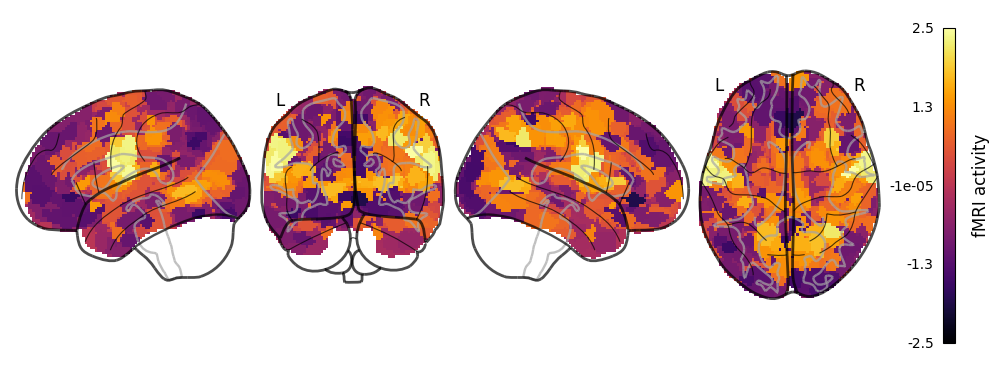

In [13]:
# Load ses-001_task-s01e02a and plot the fMRI response for the first
# transcript chunk, with a hrf_delay of 0 seconds
fmri_file_path = root_data_dir + "/algonauts_2025.competitors/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"
atlas_path = root_data_dir + "/algonauts_2025.competitors/fmri/sub-01/atlas/sub-01_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz"
dataset_name = 'ses-001_task-s01e02a'
hrf_delay = 0
chunk_index = 480  # First transcript chunk
output_img = plot_fmri_on_brain(chunk_index, fmri_file_path, atlas_path, dataset_name, hrf_delay)

In [14]:
output_img.shape

(97, 115, 97)